In [1]:
#____________________ Phase Time Calculation
import pandas as pd

# Read the DataFrame from CSV
df = pd.read_csv('df_ready.csv')

# Convert 'DateTime' column to datetime objects
df['DateTime'] = pd.to_datetime(df['DateTime'])

# Initialize new columns for planning time and navigation time
df['planning_time'] = 0
df['navigation_time'] = 0

# Initialize variables to track previous time and index for planning and navigation phases
prev_planning_time = None
prev_navigation_time = None
prev_planning_index = None
prev_navigation_index = None

# Iterate over rows
for index, row in df.iterrows():
    if row['phase'] == 'planning':
        if prev_planning_time is None:
            prev_planning_time = row['DateTime']
            prev_planning_index = index
        else:
            current_time = row['DateTime']
            planning_time = (current_time - prev_planning_time).total_seconds()
            df.at[index, 'planning_time'] = planning_time
            prev_planning_time = current_time
            prev_planning_index = index
        # Reset navigation variables when encountering planning phase
        prev_navigation_time = None
    elif row['phase'] == 'navigation':
        if prev_navigation_time is None:
            prev_navigation_time = row['DateTime']
            prev_navigation_index = index
        else:
            current_time = row['DateTime']
            navigation_time = (current_time - prev_navigation_time).total_seconds()
            df.at[index, 'navigation_time'] = navigation_time
            prev_navigation_time = current_time
            prev_navigation_index = index
        # Reset planning variables when encountering navigation phase
        prev_planning_time = None


# Group by participant and scenario, then sum the planning time and navigation time
grouped_df = df.groupby(['participant', 'scenario','taskId'])[['planning_time', 'navigation_time']].sum().reset_index()

# Print the resulting DataFrame
print(grouped_df)

# Save the DataFrame with the updated column
grouped_df.to_csv('df_phase_time.csv', index=False)

      participant  scenario  taskId  planning_time  navigation_time
0               8         1     0.0          0.000            0.000
1               8         1     1.0         60.410           65.671
2               8         1     2.0         28.774          143.625
3               8         1     3.0         17.756          109.986
4               8         1     4.0         14.255          142.439
...           ...       ...     ...            ...              ...
1074           63         4     0.0          0.000            0.000
1075           63         4     1.0         11.400           63.880
1076           63         4     2.0          9.405           60.506
1077           63         4     3.0          9.629           92.103
1078           63         4     4.0         13.208           70.901

[1079 rows x 5 columns]


In [2]:
#____________________ Phase Distance Calculation
import pandas as pd
import numpy as np

# Read the DataFrame from CSV
df = pd.read_csv('df_ready.csv')

# Initialize new columns for planning and navigation distances
df['planning_distance'] = 0.0
df['navigation_distance'] = 0.0

# Initialize variables to store the previous position
prev_posX = None
prev_posZ = None

# Iterate over rows
for index, row in df.iterrows():
    if row['phase'] == 'planning' or row['phase'] == 'navigation':
        if prev_posX is not None and prev_posZ is not None:
            # Calculate Euclidean distance between current and previous position
            distance = np.sqrt((row['posX'] - prev_posX)**2 + (row['posZ'] - prev_posZ)**2)
            if row['phase'] == 'planning':
                df.at[index, 'planning_distance'] = distance
            else:
                df.at[index, 'navigating_distance'] = distance
        # Update previous position
        prev_posX = row['posX']
        prev_posZ = row['posZ']
    else:
        # Reset previous position when phase is not planning or navigation
        prev_posX = None
        prev_posZ = None

df.to_csv('check_distance.csv')

# Group by participant and scenario, then sum the planning_distance and navigation_distance
grouped_df_distance = df.groupby(['participant', 'scenario', 'taskId'])[['planning_distance', 'navigating_distance']].sum().reset_index()

# Round the distances to two decimal places
grouped_df_distance[['planning_distance', 'navigating_distance']] = grouped_df_distance[['planning_distance', 'navigating_distance']].round(2)

# Print the resulting DataFrame
grouped_df_distance.to_csv('df_phase_distance.csv', index=False)


In [6]:
#____________________ Phase stop 
import pandas as pd

# Read the DataFrame from CSV
df = pd.read_csv('df_ready.csv')

# Initialize new columns for stops
df['stop'] = None

# Identify duplicated rows based on posX, posY, and posZ for planning phase
planning_mask = df['phase'] == 'planning'
df.loc[planning_mask & df.duplicated(subset=['posX', 'posY', 'posZ'], keep=False), 'stop'] = 'planning_stop'

# Identify duplicated rows based on posX, posY, and posZ for navigation phase
navigation_mask = df['phase'] == 'navigation'
df.loc[navigation_mask & df.duplicated(subset=['posX', 'posY', 'posZ'], keep=False), 'stop'] = 'navigation_stop'

# Initialize new columns for consecutive stops
df['planning_stop_count'] = (df['stop'] == 'planning_stop') & (df['stop'].shift(-1) != 'planning_stop')
df['navigation_stop_count'] = (df['stop'] == 'navigation_stop') & (df['stop'].shift(-1) != 'navigation_stop')


# Group by participant and scenario, then sum the consecutive stops for planning and navigation
grouped_df = df.groupby(['participant', 'scenario']).agg({
    'planning_stop_count': 'sum',
    'navigation_stop_count': 'sum'
}).reset_index()

# Rename the columns
grouped_df.columns = ['participant', 'scenario', 'planning_stop', 'navigation_stop']

# Print the resulting DataFrame
print(grouped_df)

# Save the DataFrame to a new CSV file
grouped_df.to_csv('df_phase_stop.csv', index=False)


     participant  scenario  planning_stop  navigation_stop
0              8         1             10               23
1              8         2              6               14
2              8         3             15               11
3              8         4             15               40
4              9         1              9                7
..           ...       ...            ...              ...
211           62         4             13               37
212           63         1             10               14
213           63         2              4               46
214           63         3              5               29
215           63         4              7               16

[216 rows x 4 columns]


In [7]:
#____________________ Phase stop time 
import pandas as pd

# Read the DataFrame from CSV
df = pd.read_csv('df_ready.csv')
df['DateTime'] = pd.to_datetime(df['DateTime'])

# Initialize new columns for stops
df['stop'] = None

# Identify duplicated rows based on posX, posY, and posZ for planning phase
planning_mask = df['phase'] == 'planning'
df.loc[planning_mask & df.duplicated(subset=['posX', 'posY', 'posZ'], keep=False), 'stop'] = 'planning_stop'

# Identify duplicated rows based on posX, posY, and posZ for navigation phase
navigation_mask = df['phase'] == 'navigation'
df.loc[navigation_mask & df.duplicated(subset=['posX', 'posY', 'posZ'], keep=False), 'stop'] = 'navigation_stop'

# Initialize new columns for stop time differences
df['planning_stop_time'] = None
df['navigation_stop_time'] = None

# Initialize variables to store the previous time
prev_time = None

# Iterate over rows
for index, row in df.iterrows():
    # Check if the current row is a planning_stop or navigation_stop
    if row['stop'] in ['planning_stop', 'navigation_stop']:
        # If previous time exists, calculate the time difference in seconds
        if prev_time is not None:
            time_difference = (row['DateTime'] - prev_time).total_seconds()
            # Assign the time difference to the respective column
            if row['stop'] == 'planning_stop':
                df.at[index, 'planning_stop_time_seconds'] = time_difference
            elif row['stop'] == 'navigation_stop':
                df.at[index, 'navigation_stop_time_seconds'] = time_difference
        # Update previous time
        prev_time = row['DateTime']
    else:
        # Reset previous time when the stop column is not planning_stop or navigation_stop
        prev_time = None

# Group by participant, scenario, and stop, then calculate the sum of time differences
grouped_df = df.groupby(['participant', 'scenario']).agg({
    'planning_stop_time_seconds': lambda x: round(x.sum(), 2),
    'navigation_stop_time_seconds': lambda x: round(x.sum(), 2)
}).reset_index()

# Print the resulting DataFrame
print(grouped_df)

grouped_df.to_csv('df_phase_stoptime.csv')



     participant  scenario  planning_stop_time_seconds  \
0              8         1                       55.66   
1              8         2                       30.32   
2              8         3                       11.22   
3              8         4                       47.86   
4              9         1                       56.05   
..           ...       ...                         ...   
211           62         4                       16.99   
212           63         1                       35.04   
213           63         2                       78.60   
214           63         3                       32.07   
215           63         4                        9.42   

     navigation_stop_time_seconds  
0                           60.02  
1                            6.07  
2                            2.43  
3                           61.92  
4                            9.26  
..                            ...  
211                         31.84  
212            

In [2]:
#___________________ phase_analysis_result
import pandas as pd

# Load the CSV files
df_phase_time = pd.read_csv("df_phase_time.csv")
df_phase_distance = pd.read_csv("df_phase_distance.csv")
df_phase_stop = pd.read_csv("df_phase_stop.csv")
df_phase_stoptime = pd.read_csv("df_phase_stoptime.csv")


# Merge the DataFrames
merged_df = pd.merge(df_phase_time, df_phase_distance, on=['participant', 'scenario'])
merged_df = pd.merge(merged_df, df_phase_stop, on=['participant', 'scenario'])
merged_df = pd.merge(merged_df, df_phase_stoptime, on=['participant', 'scenario'])

# Rename the column 'navigation_time' to 'navigating_time'
merged_df.rename(columns={'navigation_time': 'navigating_time'}, inplace=True)

# Calculate planning_speed and navigating_speed
merged_df['planning_speed'] = merged_df['planning_distance'] / merged_df['planning_time']
merged_df['navigating_speed'] = merged_df['navigating_distance'] / merged_df['navigating_time']

# Round the speeds to 2 decimal places
merged_df['planning_speed'] = merged_df['planning_speed'].round(2)
merged_df['navigating_speed'] = merged_df['navigating_speed'].round(2)


# Save the merged DataFrame to a new CSV file
print(merged_df)

merged_df.to_csv('result_phase_analysis.csv')


     participant  scenario  planning_time  navigating_time  planning_distance  \
0              8         1        121.195          461.721              98.12   
1              8         2         44.069          359.893              10.54   
2              8         3         58.031          248.460              14.66   
3              8         4         72.901          562.603              12.41   
4              9         1        152.907          215.555              39.40   
..           ...       ...            ...              ...                ...   
211           62         4         47.198          610.933               6.37   
212           63         1         46.558          293.891               0.14   
213           63         2         78.596          303.629               0.00   
214           63         3         50.967          289.221              11.46   
215           63         4         43.642          287.390               5.45   

     navigating_distance  p

In [4]:
#____________________ Cross_checking 
import pandas as pd
# Read the DataFrame from CSV
df_mona_group_v4 = pd.read_csv('df_mona_group_v4.csv')
df_phase_time = pd.read_csv('df_phase_time.csv')
# Merge the datasets based on 'id' and 'scenario_id'
merged_df = pd.merge(df_mona_group_v4, df_phase_time, left_on=['id', 'scenario_id'], right_on=['participant', 'scenario'], how='inner')

# Calculate the differences between 'planning_time' and 'navigation_time'
merged_df['difference_planning'] = merged_df['planning_time_x'] - merged_df['planning_time_y']
merged_df['difference_navigation'] = merged_df['navigating_time'] - merged_df['navigation_time']

# Format columns to display without scientific notation and with two decimal places
merged_df['difference_planning'] = merged_df['difference_planning'].apply(lambda x: '{:.2f}'.format(x))
merged_df['difference_navigation'] = merged_df['difference_navigation'].apply(lambda x: '{:.2f}'.format(x))



# Save the DataFrame with the updated column
merged_df.to_csv('result_difference_time_v4.csv', index=False)



Correlation between Percentage of screenlocked time and sbsod_score: 0.40195749933406105


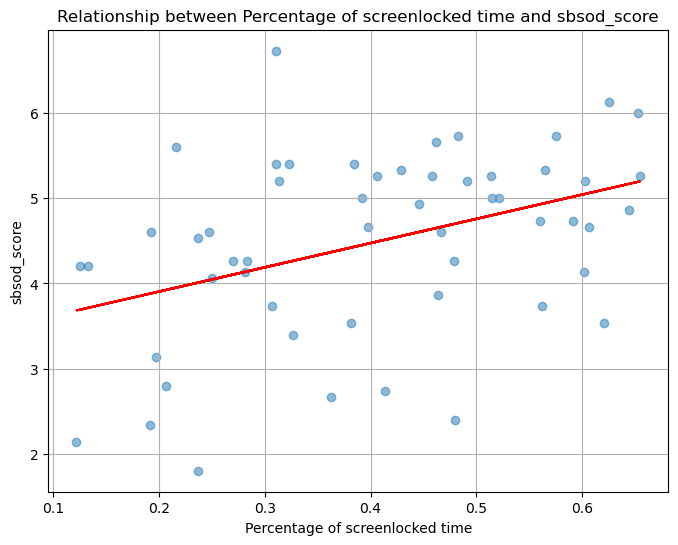

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the data
df_screenlock = pd.read_csv('screenlock.csv')

# Calculate correlation
correlation = df_screenlock['Percentage of screenlocked time'].corr(df_screenlock['sbsod_score'])
print("Correlation between Percentage of screenlocked time and sbsod_score:", correlation)

# Fit a linear regression line
slope, intercept = np.polyfit(df_screenlock['Percentage of screenlocked time'], df_screenlock['sbsod_score'], 1)

# Plot the scatter plot and regression line together
plt.figure(figsize=(8, 6))
plt.scatter(df_screenlock['Percentage of screenlocked time'], df_screenlock['sbsod_score'], alpha=0.5)
plt.plot(df_screenlock['Percentage of screenlocked time'], slope * df_screenlock['Percentage of screenlocked time'] + intercept, color='red')
plt.title('Relationship between Percentage of screenlocked time and sbsod_score')
plt.xlabel('Percentage of screenlocked time')
plt.ylabel('sbsod_score')
plt.grid(True)
plt.show()


In [9]:
import seaborn as sns
plt.figure(figsize=(8, 6))
sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.show()

ValueError: Must pass 2-d input. shape=()

<Figure size 800x600 with 0 Axes>